## 2 Layer MLP
- With hidden layer of size 64 and dropout with 0.5 probability
- Softmax at last classification layer 
- Learning rate of 0.001
- Over 50-100 epochs

In [12]:
import numpy as np
import tensorflow as tf
import argparse
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import math
import wandb
from wandb.integration.keras.callbacks import WandbMetricsLogger, WandbModelCheckpoint


encoder = load_model("../Models/encoder_250.keras")
# X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_data.npy")
# Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_labels.npy")
X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_data.npy")
Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_labels.npy")
X = encoder.predict(X)
print(X.shape)


  2/103 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step  

2025-09-19 00:09:18.314897: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 884506896 exceeds 10% of free system memory.


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
(3276, 250)


In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0015,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True
)

In [14]:
# wandb.init(

#     project="Classifier Tuning",

#     # track hyperparameters and run metadata with wandb.config
#     config={
#         "hidden_size": 64,
#         "activation_1": "tanh",
#         "dropout": 0.5,
#         "output_size": 2,
#         "output_activation": "softmax",
#         "optimizer": "adam",
#         "learning_rate": lr_schedule,
#         "loss": "sparse_categorical_crossentropy",
#         "metric": "accuracy",
#         "epochs": 50,
#         "batch_size": 32
#     }
# )

# config = wandb.config

In [15]:
class MLPClassifier(tf.keras.Model):
    def __init__(self, hidden_size, dropout_rate):
        super(MLPClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        self.classifier = tf.keras.Sequential([
            layers.Dense(hidden_size, activation='tanh'),
            layers.Dropout(dropout_rate),
            layers.Dense(2, activation='softmax')
        ])

    def call(self, inputs):
        return self.classifier(inputs)

In [16]:
# Split into train (80%), val (20%) and test (20%) 
X_train, X_val, y_train, y_val= train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [17]:
print(f'Training data shape: {X_train.shape}')
print(f'Val data shape: {X_val.shape}')
# print(f'Test data shape: {X_test.shape}')


Training data shape: (2620, 250)
Val data shape: (656, 250)


In [18]:
model = MLPClassifier(hidden_size=64, dropout_rate=0.5)

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=10,
    restore_best_weights=True
)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            )

print("Training started....")
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,    
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping,
            #    WandbMetricsLogger(),
            #    WandbModelCheckpoint("models.keras",save_best_only=True,monitor='accuracy')
               ]
)
# wandb.finish()
print("Training completed!")


Training started....
Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7294 - loss: 0.5277 - val_accuracy: 0.7957 - val_loss: 0.4193
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8038 - loss: 0.4380 - val_accuracy: 0.8262 - val_loss: 0.3842
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8210 - loss: 0.4109 - val_accuracy: 0.8491 - val_loss: 0.3559
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8302 - loss: 0.3960 - val_accuracy: 0.8567 - val_loss: 0.3484
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.3917 - val_accuracy: 0.8689 - val_loss: 0.3349
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.3649 - val_accuracy: 0.8552 - val_loss: 0.3425
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8485 - loss: 0.3542 - val_accuracy: 0.8659 - val_loss: 0.3338
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8553 - loss: 0.3473 - val_accurac

In [19]:
model.classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,194 (63.26 KB)

 Trainable params: 16,194 (63.26 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8948 - loss: 0.2807 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
TN: 303, FP: 25, FN: 44, TP: 284
AUC: 0.9537663593099345


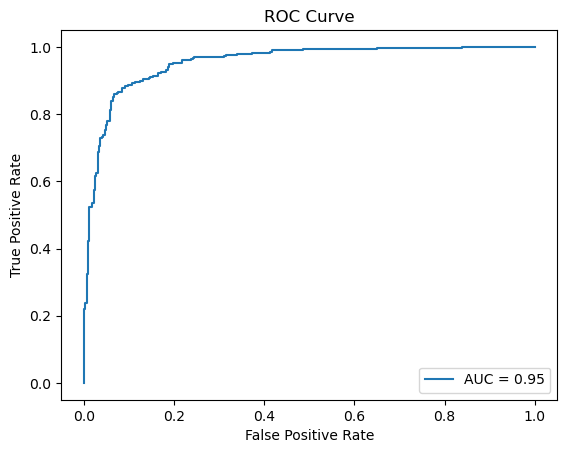

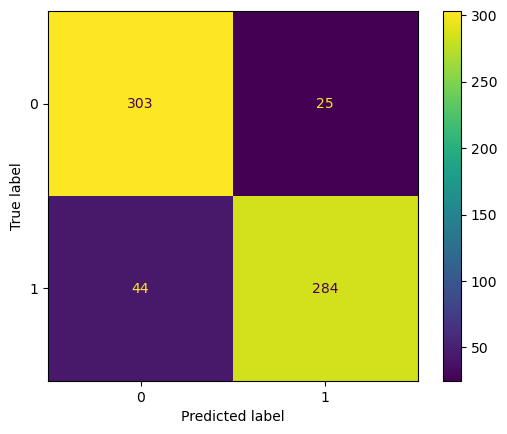

Test loss: 0.2807161509990692
Test Accuracy 0.894817054271698


In [20]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

loss, accuracy = model.evaluate(X_val, y_val)

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

if len(np.unique(y_val)) == 2:
    auc = roc_auc_score(y_val, y_pred_probs[:, 1])
    print(f'AUC: {auc}')
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs[:, 1])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f'Test loss: {loss}')
print(f'Test Accuracy {accuracy}')

In [21]:
# model.classifier.save(filepath="../Models/classifier_250_baseline.keras")